# 1. Installing packages

In [2]:
!pip install wordcloud

You should consider upgrading via the 'pip install --upgrade pip' command.


# 2. Importing libraries

In [121]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
from wordcloud import WordCloud
import unicodedata
from nltk import WordNetLemmatizer
nltk.download('wordnet')
from nltk import PorterStemmer
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# 3. Data cleaning and wrangling

In [4]:
df = pd.read_csv("dataset_sample.csv")
df.head()

,Id,Title,Body,Tags
0,1,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...
1,2,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox
2,3,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning
3,4,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding
4,5,How to modify whois contact details?,<pre><code>function modify(.......)\n{\n $mco...,php api file-get-contents


## a. Figure out how many types of HTML tags exist in the *Body* column

In order to do this, we can use the *regex* functionality of dataframes to figure out all the unique cases where the pattern *<???>* is used. This is a standard HTML format where chunks of code or text is embedded inside the < and > characters. 

In [5]:
#Finding all instances where an HTML pattern is seen in the dataset
html_tags = df['Body'].str.findall(r'(</\w*>|<\w*>)')
print ("Printing first 5 rows of dataset with all HTML tags")
print (html_tags.head())
print ()

#Combining all the HTML tags in the dataset to find unique values
html_tags_all = []
for i in html_tags:
    html_tags_all.extend(i)
print ('Printing a list of all HTML tags in the dataset')
print (html_tags_all[:10])

Printing first 5 rows of dataset with all HTML tags
0                               [<p>, </p>, <p>, </p>]
1                               [<p>, </p>, <p>, </p>]
2    [<p>, </p>, <pre>, <code>, </code>, </pre>, <p...
3    [<p>, </p>, <p>, </p>, <p>, </p>, <p>, </p>, <...
4    [<pre>, <code>, </code>, </pre>, <p>, </p>, <c...
Name: Body, dtype: object

Printing a list of all HTML tags in the dataset
['<p>', '</p>', '<p>', '</p>', '<p>', '</p>', '<p>', '</p>', '<p>', '</p>']


Now that we have extracted all HTML tags in the dataset and combined them into one list, we need to verify if we were actually able to capture all the tags. To do this, we can compare the total number of tags in the initial dataset to the combined list. 

In [6]:
print ("Number of HTML tags in the first regex dataset")
print (sum(html_tags.apply(len)))
print ()

print ("Number of HTML tags in the combined list")
print (len(html_tags_all))

Number of HTML tags in the first regex dataset
7476

Number of HTML tags in the combined list
7476


Having verified that our parsing works correctly, we can now pick out all the unique HTML tags. 

In [7]:
#Printing unique HTML tags
unique_html = list(set(html_tags_all))
print ("Unique HTML tags")
print (unique_html)

Unique HTML tags
['<pre>', '<blockquote>', '</p>', '<ol>', '</em>', '<h3>', '</li>', '</pre>', '<hr>', '</h1>', '<code>', '</a>', '</ol>', '<p>', '<b>', '<h2>', '</strong>', '</h2>', '<li>', '</code>', '<strong>', '<br>', '<em>', '<BR>', '<h1>', '</ul>', '</h3>', '</blockquote>', '<ul>', '</b>']


Using the unique HTML tags, we can find the frequency of each tag in the dataset.

In [8]:
html_tags_total = []

for i in unique_html:
    html_tags_total.append(sum(df['Body'].str.findall(r'('+i+')').apply(len)))

df_html = pd.DataFrame()
df_html['Tag'] = unique_html
df_html['Count'] = html_tags_total
df_html['Tag'] = df_html['Tag'].str.strip('<,>')
df_html = df_html.sort_values('Count',ascending=False)
df_html

,Tag,Count
2,/p,2058
13,p,2058
10,code,805
19,/code,805
7,/pre,464
0,pre,461
11,/a,135
16,/strong,128
20,strong,128
6,/li,81


The frequency of each HTML tag is shown in the table above in descending order. From this data, we notice that every tag has a complimentary tag with a forward slash. The forward slash indicates the end of the text for the respective tag. For example the text in a *p* tag ends with a */p*. Hence every tag has the same frequency as that of it's forward slash compliment. So the frequency of *p* is the same as that for */p*.

Text(0, 0.5, 'Count')

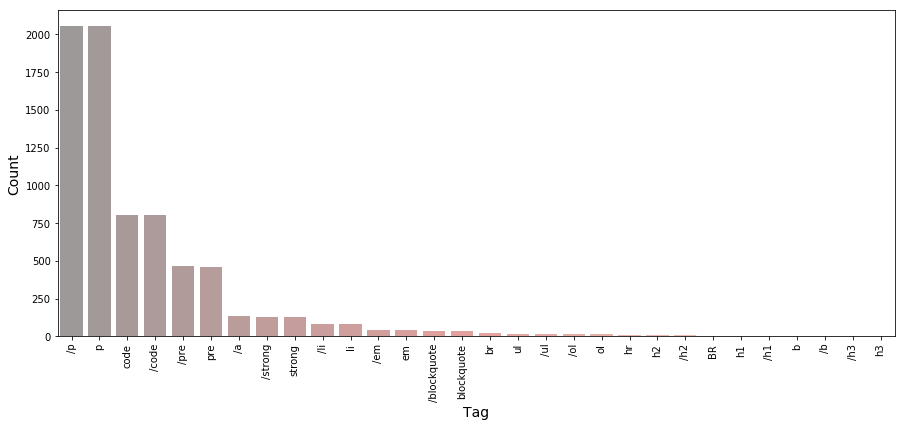

In [9]:
#Plotting frequency of tags in the dataset
plt.figure(figsize=(15,6))
sns.barplot(x='Tag',y='Count',data=df_html,alpha=0.5,palette='Reds_d')
plt.xticks(rotation=90)
plt.xlabel('Tag',size=14)
plt.ylabel('Count',size=14)

One thing to note would be that there could be more than one type of tag in an instance. To somewhat visualize the occurrence of these tags in each instance, we can plot the distribution for each tag stacked on top of another as done below. 

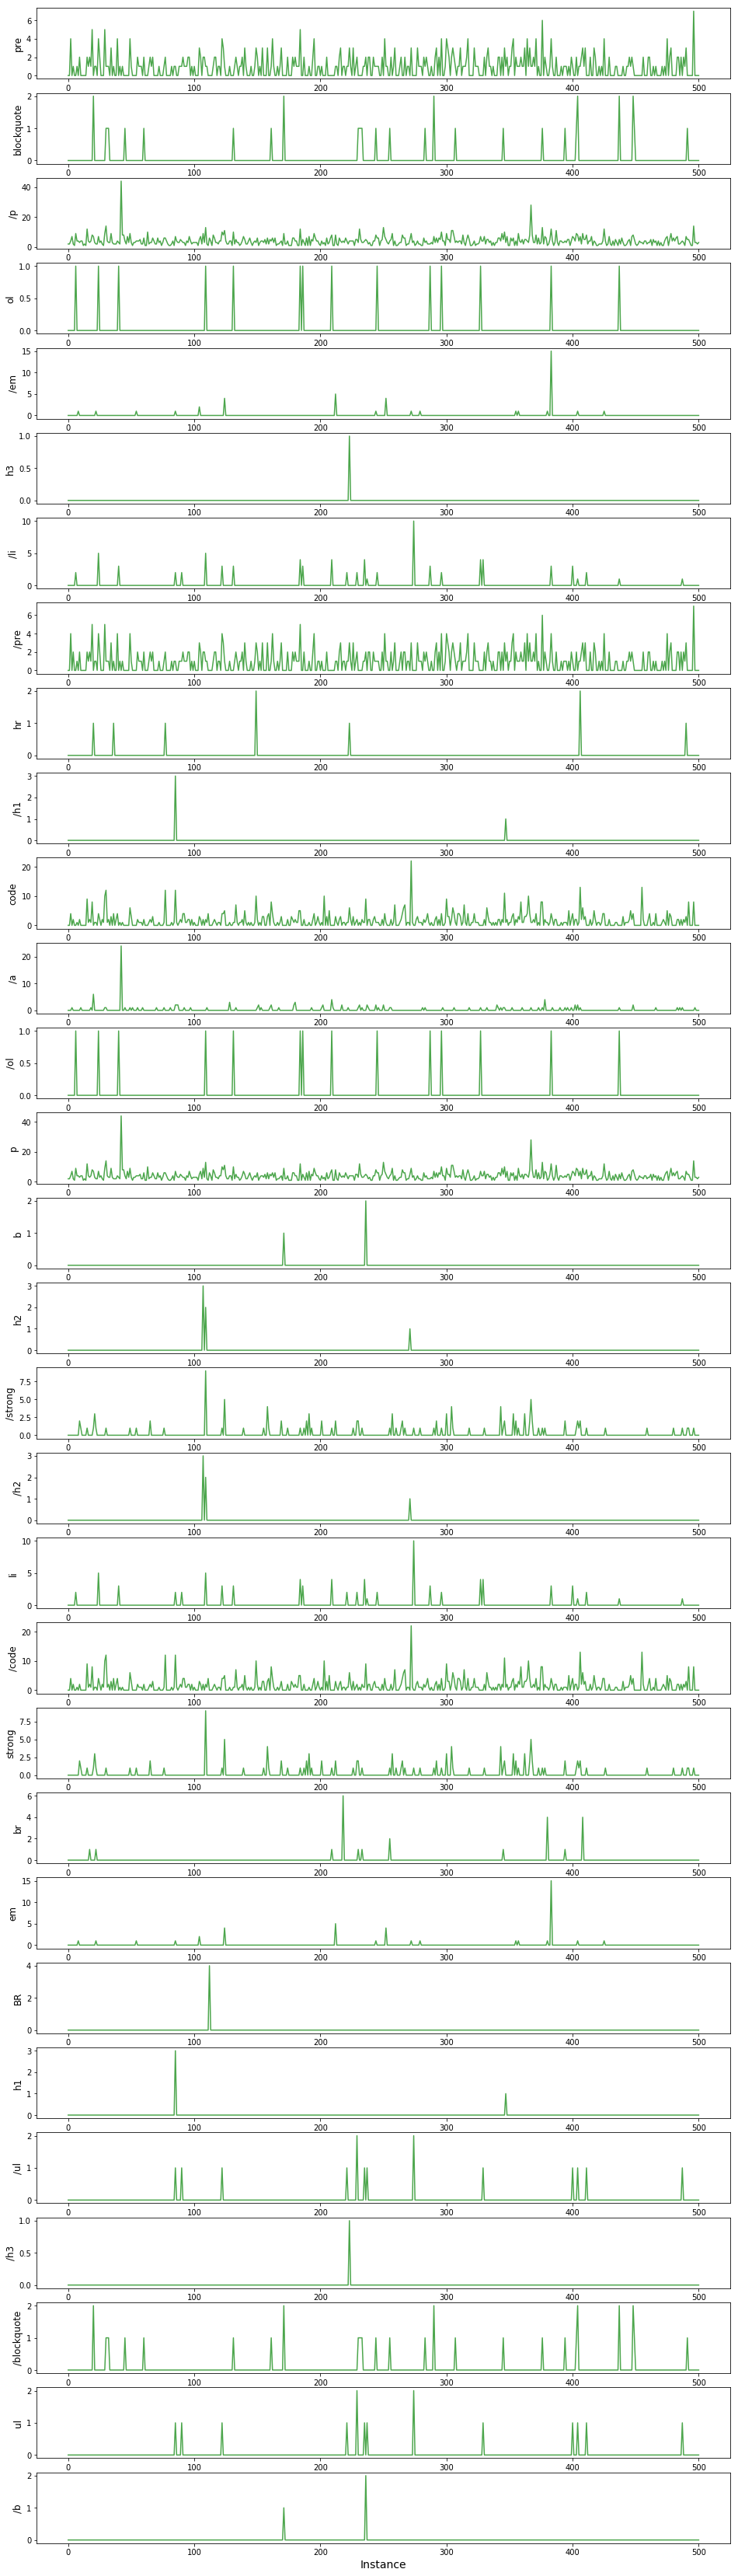

In [10]:
#Printing frequency of each tag in the dataset as separate plots stacked on top of one another
#to show where different tags overlap
plt.figure(figsize=(16,60))

for i,j in enumerate(unique_html):
    plt.subplot(len(unique_html),1,i+1)
    plt.plot(df['Body'].str.findall(r'('+j+')').apply(len),alpha=0.7,c='green')
    plt.xlabel('Instance',size=14)
    plt.ylabel(df_html['Tag'][i],size=12)

The visualization above shows the frequency of each tag across each instance. However, since each tag also contains a complimentary tag with a slash, we can simply plot just the ones without the slash, as shown below. 

In [11]:
#Selecting tags without the forward slash
slash_bool_mask = df_html['Tag'].str.contains('/')
#Flipping the boolean mask that captured instances containing '/'
df_html_no_slash = df_html[~slash_bool_mask]
df_html_no_slash.head()

,Tag,Count
13,p,2058
10,code,805
0,pre,461
20,strong,128
18,li,81


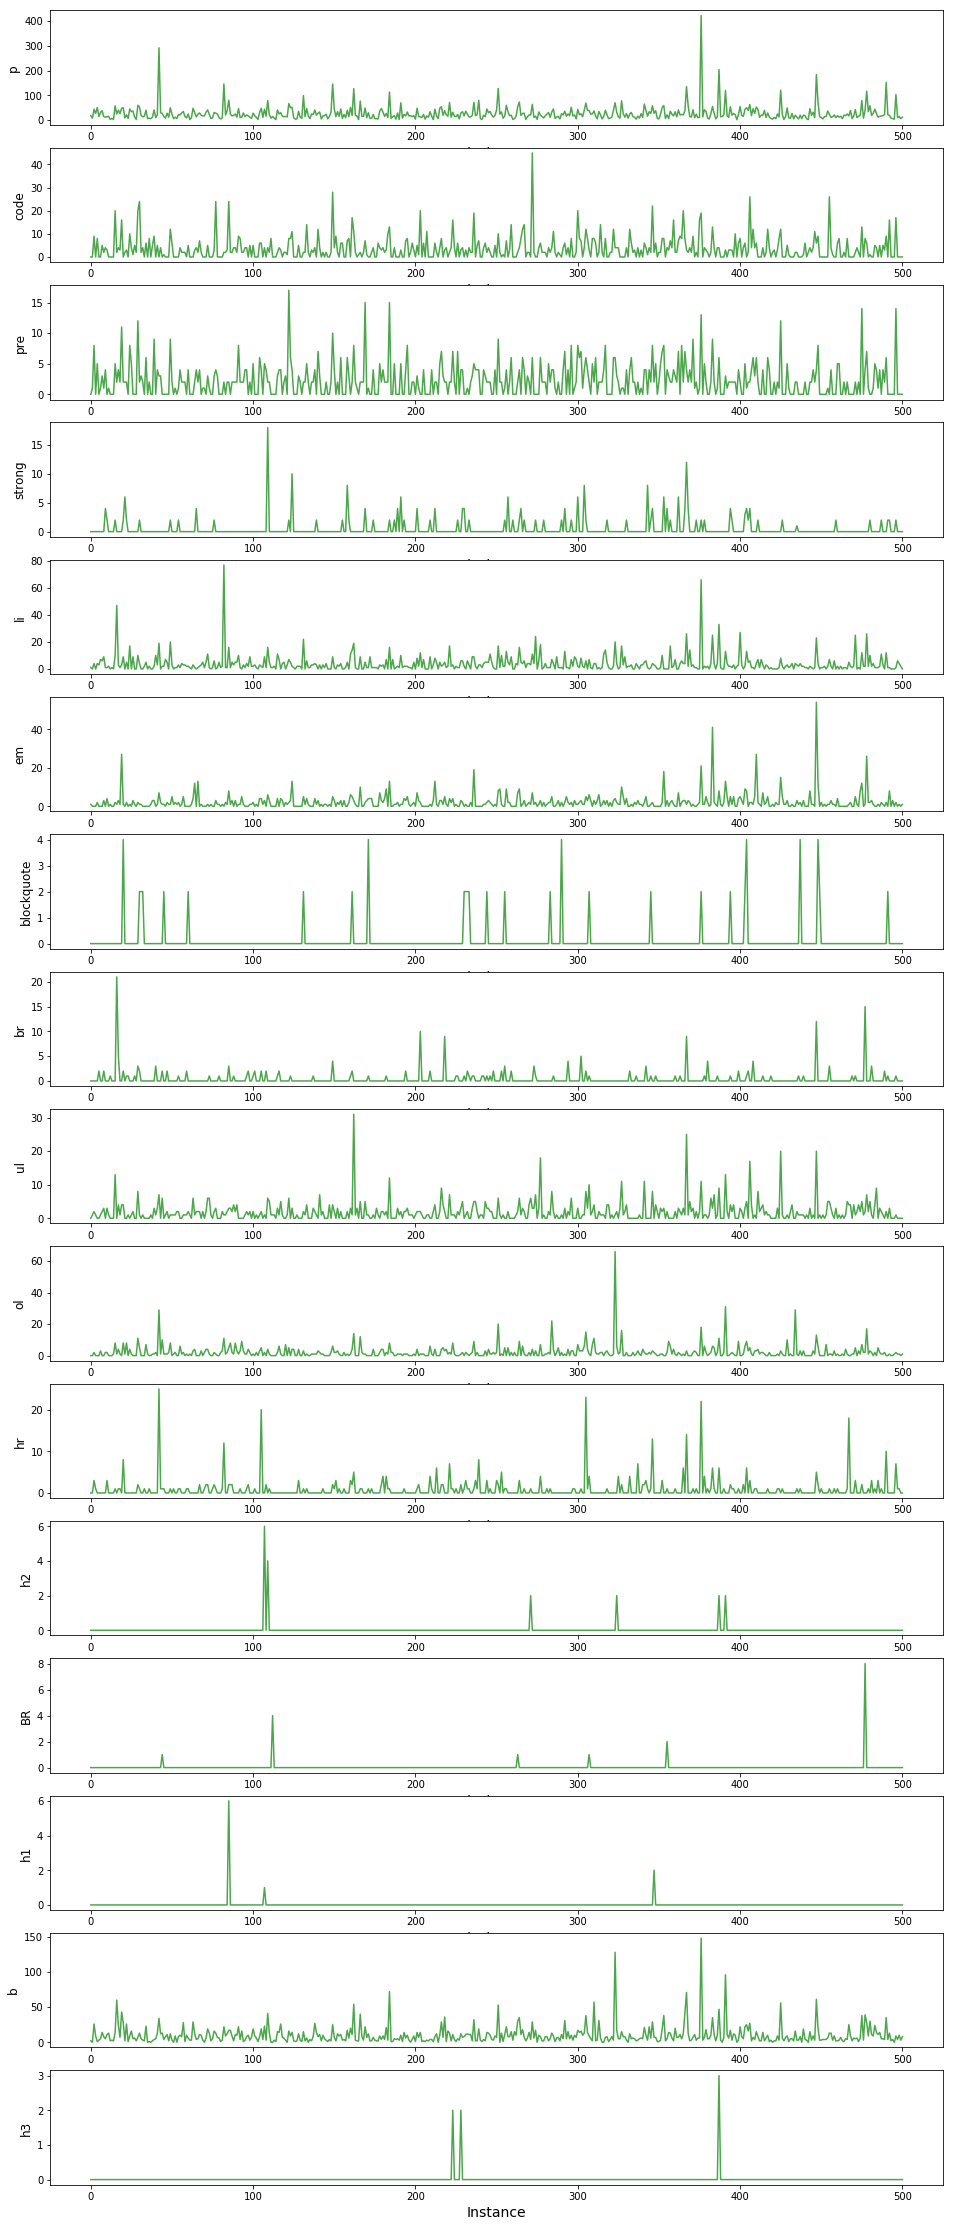

In [12]:
#Printing frequency of each tag in the dataset as separate plots stacked on top of one another
#to show where different tags overlap
plt.figure(figsize=(16,40))

for i,j in enumerate(df_html_no_slash['Tag']):
    plt.subplot(len(df_html_no_slash['Tag']),1,i+1)
    plt.plot(df['Body'].str.findall(r'('+j+')').apply(len),alpha=0.7,c='green')
    #plt.scatter(range(len(df['Body'].str.findall(r'('+j+')').apply(len))),df['Body'].str.findall(r'('+j+')').apply(len),alpha=0.7,c='green')
    plt.xlabel('Instance',size=14)
    plt.ylabel(df_html_no_slash['Tag'].iloc[i],size=12)
    #plt.ylim(0,200)

From the plots above, if we look at the b tag for instance, it has a few high frequencies between instances 300 and 400. Otherwise, it is mostly below 50. Tags such as p has frequencies that are higher indicating that it's one of the more predominant tags in the dataset. 

## b. Removing tags from *Title* and *Body* to just keep the text to be used for *bag of words*

In [13]:
#Removing tags from the Body column
df_body_text = df.copy()
df_body_text['Body'] = df_body_text['Body'].str.replace(r'(</\w*>|<\w*>)','')
df_body_text['Body'].head()

0    I'd like to check if an uploaded file is an im...
1    In my favorite editor (vim), I regularly use c...
2    I am import matlab file and construct a data f...
3    This is probably very simple, but I simply can...
4    function modify(.......)\n{\n  $mcontact = fil...
Name: Body, dtype: object

In [14]:
#Checking to see if the removal worked
sum(df_body_text['Body'].str.findall(r'(</\w*>|<\w*>)').apply(len))

0

Since the sum of the lengths of each row containing any tags is 0 for the new dataframe, we can be convinced that the tags were removed successfully. 

Let's take a look at the text of the first row. 

In [15]:
df_body_text['Body'][0]

"I'd like to check if an uploaded file is an image file (e.g png, jpg, jpeg, gif, bmp) or another file. The problem is that I'm using Uploadify to upload the files, which changes the mime type and gives a 'text/octal' or something as the mime type, no matter which file type you upload.\n\nIs there a way to check if the uploaded file is an image apart from checking the file extension using PHP?\n"

Now let's take a look at the original version of this text with the tags. 

In [16]:
df['Body'][0]

"<p>I'd like to check if an uploaded file is an image file (e.g png, jpg, jpeg, gif, bmp) or another file. The problem is that I'm using Uploadify to upload the files, which changes the mime type and gives a 'text/octal' or something as the mime type, no matter which file type you upload.</p>\n\n<p>Is there a way to check if the uploaded file is an image apart from checking the file extension using PHP?</p>\n"

## c. Removing \n (newline) characters from the text

In [17]:
#Searching for newline characters in the Body
df_body_text['Body'].str.findall(r'(\n)').apply(len).head()

0      3
1      3
2    201
3     13
4     20
Name: Body, dtype: int64

In [18]:
#Total newline characters in the Body
print ("Number of newline characters in the Title column: ",sum(df_body_text['Body'].str.findall(r'(\n)').apply(len)))

Number of newline characters in the Title column:  12122


In [19]:
#Searching for newline characters in the Title
df_body_text['Title'].str.findall(r'(\n)').apply(len).head()

0    0
1    0
2    0
3    0
4    0
Name: Title, dtype: int64

In [20]:
#Total newline characters in the Title
print ("Number of newline characters in the Title column: ",sum(df_body_text['Title'].str.findall(r'(\n)').apply(len)))

Number of newline characters in the Title column:  0


It seems like there are **12122 newline characters** in the Body column but none in the Title column. Hence we only need to handle these characters for the body. 

Text(0, 0.5, 'Frequency')

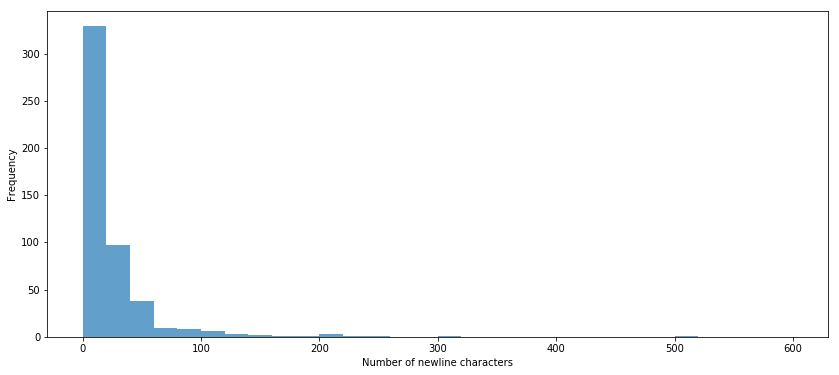

In [21]:
#Plotting newline character frequencies across instances
plt.figure(figsize=(14,6))
plt.hist(df_body_text['Body'].str.findall(r'(\n)').apply(len),range=(0,600),bins=30,alpha=0.7)
plt.xlabel('Number of newline characters')
plt.ylabel('Frequency')

The above plot shows that most instances contain 0 newline characters. About a 100 instances contain less than 40 newlines and more than 20 newlines while the numbers taper off quickly after that. Hence the distribution is highly right skewed. 

Text(0, 0.5, 'Frequency')

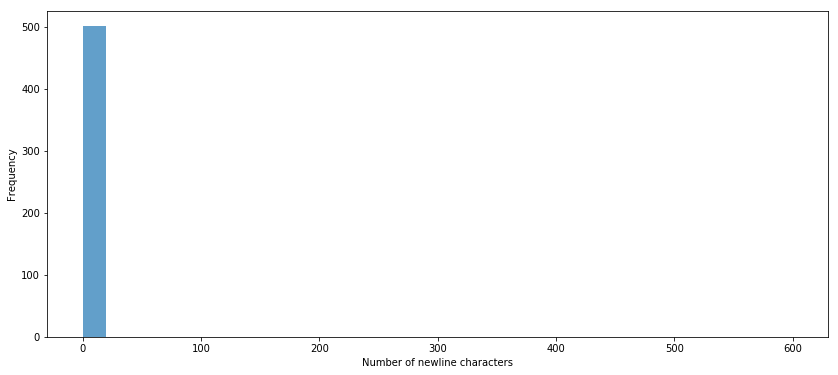

In [22]:
#Plotting newline character frequencies across instances
plt.figure(figsize=(14,6))
plt.hist(df_body_text['Title'].str.findall(r'(\n)').apply(len),range=(0,600),bins=30,alpha=0.7)
plt.xlabel('Number of newline characters')
plt.ylabel('Frequency')

As expected, none of the Title instances contain any newline characters. 

In [23]:
#Removing newline characters
df_body_text['Body'] = df_body_text['Body'].str.replace(r'(\n)','')
df_body_text['Body'].head()

0    I'd like to check if an uploaded file is an im...
1    In my favorite editor (vim), I regularly use c...
2    I am import matlab file and construct a data f...
3    This is probably very simple, but I simply can...
4    function modify(.......){  $mcontact = file_ge...
Name: Body, dtype: object

In [24]:
df_body_text['Body'][0]

"I'd like to check if an uploaded file is an image file (e.g png, jpg, jpeg, gif, bmp) or another file. The problem is that I'm using Uploadify to upload the files, which changes the mime type and gives a 'text/octal' or something as the mime type, no matter which file type you upload.Is there a way to check if the uploaded file is an image apart from checking the file extension using PHP?"

We have now removed both tags and newline characters from the body of the text. Let's take a look at some more rows to verify. 

In [25]:
df_body_text['Body'][1]

'In my favorite editor (vim), I regularly use ctrl-w to execute a certain action. Now, it quite often happens to me that firefox is the active window (on windows) while I still look at vim (thinking vim is the active window) and press ctrl-w which closes firefox. This is not what I want. Is there a way to stop ctrl-w from closing firefox?Rene'

In [26]:
df_body_text['Body'][2]

'I am import matlab file and construct a data frame, matlab file contains two columns with and each row maintain a cell that has a matrix, I construct a dataframe to run random forest. But I am getting following error. Error in model.frame.default(formula = expert_data_frame$t_labels ~ .,  :   invalid type (list) for variable \'expert_data_frame$t_labels\'Here is the code how I import the matlab file and construct the dataframe:all_exp_traintest &lt;- readMat(all_exp_filepath);len = length(all_exp_traintest$exp.traintest)/2;    for (i in 1:len) {      expert_train_df &lt;- data.frame(all_exp_traintest$exp.traintest[i]);      labels = data.frame(all_exp_traintest$exp.traintest[i+302]);      names(labels)[1] &lt;- "t_labels";      expert_train_df$t_labels &lt;- labels;      expert_data_frame &lt;- data.frame(expert_train_df);      rf_model = randomForest(expert_data_frame$t_labels ~., data=expert_data_frame, importance=TRUE, do.trace=100);    }Structure of the Matlab input file[56x12 dou

In the above three examples, the first 2 instances seem to have normal text whereas the third instance seems to contain a lot of data and numbers. There also appears to be some code in the text. Such instances will be harder to handle than others but we will deal with these complexities later. 

### Finding any tags in the *Title* column

In [27]:
#Checking the number of tags in the Title column
html_title = df['Title'].str.findall(r'(</\w*>|<\w*>)')
sum(html_title.apply(len))

2

Looks like there are just 2 tags in the *Title* column. Let's pick these ones out. 

In [28]:
df[df['Title'].str.contains(r'(</\w*>|<\w*>)')]

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  if __name__ == '__main__':


,Id,Title,Body,Tags
27,28,<p> instead of <br />,<p>I've been wondering if I can use <code>&lt;...,html semantic line-breaks
161,162,Confirm or deny: The XmlSerializer cannot seri...,"<p>The documentation for the <a href=""http://m...",c# .net serialization documentation xmlserializer


In [29]:
df['Title'][161]

'Confirm or deny: The XmlSerializer cannot serialize the following: arrays of ArrayList and arrays of List<T>'

In [30]:
df['Title'][27]

'<p> instead of <br />'

In [31]:
df_body_text['Title'] = df_body_text['Title'].str.replace(r'(</\w*>|<\w*>)','')

In [32]:
df_body_text[df_body_text['Title'].str.contains(r'(</\w*>|<\w*>)')]

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  if __name__ == '__main__':


,Id,Title,Body,Tags


As we can't find any tags in the *Title* column, we can confirm that the tags have now been removed. 

## d. Word tokenization

Tokenization splits a sentence or text document into tokens which could be words, special characters, punctuations etc. Hence, it's slightly more effective than simply using the **split** function. 

In [33]:
df_text = df_body_text.copy()
df_text.head()

,Id,Title,Body,Tags
0,1,How to check if an uploaded file is an image w...,I'd like to check if an uploaded file is an im...,php image-processing file-upload upload mime-t...
1,2,How can I prevent firefox from closing when I ...,"In my favorite editor (vim), I regularly use c...",firefox
2,3,R Error Invalid type (list) for variable,I am import matlab file and construct a data f...,r matlab machine-learning
3,4,How do I replace special characters in a URL?,"This is probably very simple, but I simply can...",c# url encoding
4,5,How to modify whois contact details?,function modify(.......){ $mcontact = file_ge...,php api file-get-contents


In [34]:
#Applying tokenization to the text
df_text['Title'] = df_text['Title'].apply(word_tokenize)
df_text['Body'] = df_text['Body'].apply(word_tokenize)
df_text['Tags'] = df_text['Tags'].apply(word_tokenize)
df_text.head()

,Id,Title,Body,Tags
0,1,"[How, to, check, if, an, uploaded, file, is, a...","[I, 'd, like, to, check, if, an, uploaded, fil...","[php, image-processing, file-upload, upload, m..."
1,2,"[How, can, I, prevent, firefox, from, closing,...","[In, my, favorite, editor, (, vim, ), ,, I, re...",[firefox]
2,3,"[R, Error, Invalid, type, (, list, ), for, var...","[I, am, import, matlab, file, and, construct, ...","[r, matlab, machine-learning]"
3,4,"[How, do, I, replace, special, characters, in,...","[This, is, probably, very, simple, ,, but, I, ...","[c, #, url, encoding]"
4,5,"[How, to, modify, whois, contact, details, ?]","[function, modify, (, ..., ..., ., ), {, $, mc...","[php, api, file-get-contents]"


## e. Changing all words to lowercase

In [35]:
def list_to_lower(list_of_words):
    to_lower = [x.lower() for x in list_of_words]
    return to_lower

In [36]:
df_text['Title'] = df_text['Title'].apply(list_to_lower)
df_text['Body'] = df_text['Body'].apply(list_to_lower)
df_text['Body'].head()

0    [i, 'd, like, to, check, if, an, uploaded, fil...
1    [in, my, favorite, editor, (, vim, ), ,, i, re...
2    [i, am, import, matlab, file, and, construct, ...
3    [this, is, probably, very, simple, ,, but, i, ...
4    [function, modify, (, ..., ..., ., ), {, $, mc...
Name: Body, dtype: object

The first 5 instances confirm that the words have been converted to lowercase. 

## f. Handling stopwords, special characters and symbols

First we extract a list of all stopwords in English using the *stopwords* function from the *nltk* library.

In [37]:
#Retrieving all stopwords in English
stop_words = stopwords.words('english')
print ("First 10 stopwords")
print (stop_words[:10])

First 10 stopwords
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


To check for the above stopwords in our dataframe, we first write a function which takes in a list of tokenized words and returns the same list without the stopwords as shown below. 

In [38]:
def remove_stop_words(list_of_tokenized_words):
    no_stops = [i for i in list_of_tokenized_words if i not in stop_words]
    return no_stops

In [39]:
df_text['Title'] = df_text['Title'].apply(remove_stop_words)
print ("Printing the first 10 instances of the Title column without stopwords")
print ()
print (df_text['Title'].head(10))
print ()
print ()
print ()
df_text['Body'] = df_text['Body'].apply(remove_stop_words)
print ("Printing the first 10 instances of the Body column without stopwords")
print ()
print (df_text['Body'].head())

Printing the first 10 instances of the Title column without stopwords

0    [check, uploaded, file, image, without, mime, ...
1           [prevent, firefox, closing, press, ctrl-w]
2      [r, error, invalid, type, (, list, ), variable]
3               [replace, special, characters, url, ?]
4                 [modify, whois, contact, details, ?]
5     [setting, proxy, active, directory, environment]
6                       [draw, barplot, way, coreplot]
7                   [fetch, xml, feed, using, asp.net]
8           [.net, library, generating, javascript, ?]
9    [sql, server, :, procedure, call, ,, inline, c...
Name: Title, dtype: object



Printing the first 10 instances of the Body column without stopwords

0    ['d, like, check, uploaded, file, image, file,...
1    [favorite, editor, (, vim, ), ,, regularly, us...
2    [import, matlab, file, construct, data, frame,...
3    [probably, simple, ,, simply, find, answer, :,...
4    [function, modify, (, ..., ..., ., ), {, $, mc...
Name

Looks like the removal of stopwords was successful to a great extent. However, there are still words such as *I, The and 'd* which also behave as potential stopwords. We can figure out the other potential stopwords as we create a distribution of the highest occurring words as we did before. 

In [40]:
#Removing the additional found stopwords
stop_words.append("I")
stop_words.append("'d")
stop_words.append('The')

In [41]:
stop_words[-5:]

['wouldn', "wouldn't", 'I', "'d", 'The']

Now let's apply the stopword removing function again

In [42]:
df_text['Title'] = df_text['Title'].apply(remove_stop_words)
print ("Printing the first 10 instances of the Title column without stopwords")
print ()
print (df_text['Title'].head())
print ()
print ()
print ()
df_text['Body'] = df_text['Body'].apply(remove_stop_words)
print ("Printing the first 10 instances of the Body column without stopwords")
print ()
print (df_text['Body'].head())

Printing the first 10 instances of the Title column without stopwords

0    [check, uploaded, file, image, without, mime, ...
1           [prevent, firefox, closing, press, ctrl-w]
2      [r, error, invalid, type, (, list, ), variable]
3               [replace, special, characters, url, ?]
4                 [modify, whois, contact, details, ?]
Name: Title, dtype: object



Printing the first 10 instances of the Body column without stopwords

0    [like, check, uploaded, file, image, file, (, ...
1    [favorite, editor, (, vim, ), ,, regularly, us...
2    [import, matlab, file, construct, data, frame,...
3    [probably, simple, ,, simply, find, answer, :,...
4    [function, modify, (, ..., ..., ., ), {, $, mc...
Name: Body, dtype: object


Once again, let's check the same instances as before to verify that the stopwords are gone. 

In [43]:
print (df_text['Body'][0])

['like', 'check', 'uploaded', 'file', 'image', 'file', '(', 'e.g', 'png', ',', 'jpg', ',', 'jpeg', ',', 'gif', ',', 'bmp', ')', 'another', 'file', '.', 'problem', "'m", 'using', 'uploadify', 'upload', 'files', ',', 'changes', 'mime', 'type', 'gives', "'text/octal", "'", 'something', 'mime', 'type', ',', 'matter', 'file', 'type', 'upload.is', 'way', 'check', 'uploaded', 'file', 'image', 'apart', 'checking', 'file', 'extension', 'using', 'php', '?']


In the above example, the words *I, The and 'd* are now removed.

Let's get the word frequencies again.

In [44]:
def combine_list_of_words(word_list):
    combined_list = []
    for i in word_list:
        combined_list.extend(i)
    return combined_list

In [45]:
title_words = combine_list_of_words(df_text['Title'])
title_words[:10]

['check',
 'uploaded',
 'file',
 'image',
 'without',
 'mime',
 'type',
 '?',
 'prevent',
 'firefox']

In [46]:
body_words = combine_list_of_words(df_text['Body'])
body_words[:10]

['like', 'check', 'uploaded', 'file', 'image', 'file', '(', 'e.g', 'png', ',']

In [47]:
df_title_words = pd.DataFrame()
df_title_words['word'] = nltk.FreqDist(title_words).keys()
df_title_words['freq'] = nltk.FreqDist(title_words).values()

df_title_words = df_title_words.sort_values("freq",ascending=False)
df_title_words.head(50)

,word,freq
7,?,151
48,:,38
16,(,37
18,),37
40,using,37
51,",",35
2,file,20
82,'',18
106,get,17
144,-,17


In [48]:
df_body_words = pd.DataFrame()
df_body_words['word'] = nltk.FreqDist(body_words).keys()
df_body_words['freq'] = nltk.FreqDist(body_words).values()

df_body_words = df_body_words.sort_values("freq",ascending=False)
df_body_words.head(50)

,word,freq
98,;,4448
13,),3372
5,(,3345
8,",",2786
96,&,2598
116,'',2571
88,:,2216
15,.,1531
133,gt,1367
97,lt,1131


### Creating a custom list of words, characters and symbols to remove

Looking at the newly ordered highest occurring words above, there are still characters like *(, & and <* that are occur quite often but do not add much value to the analysis. 

Next we can manually put such characters in a list and append to the original stopwords list, and then remove them from our dataset. We can also add single digits to this removal list.

In [49]:
#Manually adding specific characters and symbols that could 
add_stop_words = ['(',')','{','}','<','>','[',']','*','?','!','&','...','``','=',':',';','/','@',"'","''",',','"','-','--',
                  '$','.','+','%','//','..',"n't","'m","'s",'It','what','how','why','when','where','lt','gt','na',"'ve'",'href=','rel=']
from_title = ['using','file','get','use','user']
digits = range(10)

add_stop_words.extend(from_title)
add_stop_words.extend(digits)
add_stop_words.extend(map(str,digits))
add_stop_words

['(',
 ')',
 '{',
 '}',
 '<',
 '>',
 '[',
 ']',
 '*',
 '?',
 '!',
 '&',
 '...',
 '``',
 '=',
 ':',
 ';',
 '/',
 '@',
 "'",
 "''",
 ',',
 '"',
 '-',
 '--',
 '$',
 '.',
 '+',
 '%',
 '//',
 '..',
 "n't",
 "'m",
 "'s",
 'It',
 'what',
 'how',
 'why',
 'when',
 'where',
 'lt',
 'gt',
 'na',
 "'ve'",
 'href=',
 'rel=',
 'using',
 'file',
 'get',
 'use',
 'user',
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9']

In [50]:
stop_words.extend(add_stop_words)
stop_words[-20:]

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9']

In [51]:
df_text['Title'] = df_text['Title'].apply(remove_stop_words)
print ("Printing the first 10 instances of the Title column without stopwords")
print ()
print (df_text['Title'].head())
print ()
print ()
print ()
df_text['Body'] = df_text['Body'].apply(remove_stop_words)
print ("Printing the first 10 instances of the Body column without stopwords")
print ()
print (df_text['Body'].head())

Printing the first 10 instances of the Title column without stopwords

0    [check, uploaded, image, without, mime, type]
1       [prevent, firefox, closing, press, ctrl-w]
2        [r, error, invalid, type, list, variable]
3              [replace, special, characters, url]
4                [modify, whois, contact, details]
Name: Title, dtype: object



Printing the first 10 instances of the Body column without stopwords

0    [like, check, uploaded, image, e.g, png, jpg, ...
1    [favorite, editor, vim, regularly, ctrl-w, exe...
2    [import, matlab, construct, data, frame, matla...
3    [probably, simple, simply, find, answer, basic...
4    [function, modify, mcontact, file_get_contents...
Name: Body, dtype: object


## g. Lemmatization using *verb* Part of Speech (POS)

Here, we are going to apply lemmatization in order to reduce different variations of a word to a single word. For example, *runs, ran and running* are all going to be changed to the root word *run*. However, we need to provide a context for the change. In this example, the context or POS is set to a **verb**. Hence, all the variations are changed to the verb form. By default, lemmatizer uses the noun form. 

In our case, verb would be the most appropriate POS to use, especially for the body column, since a lot of the questions are about the user wanting to do something or something that they have already tried. This will allow us to group all the variations of a word together for topic modeling. 

We have not opted for the *PorterStemmer* method as that tends to reduce words to root words that may not be in the English language. 

In [52]:
#Example
lem = nltk.WordNetLemmatizer()
lem.lemmatize('simply',pos='v')

'simply'

In [53]:
def list_lemmatize(list_of_tokens):
    lemmatized = [lem.lemmatize(x,pos='v') for x in list_of_tokens]
    return lemmatized

In [54]:
#Applying lemmatization to our dataset
df_text_title = df_text['Title'].apply(list_lemmatize)
df_text_body = df_text['Body'].apply(list_lemmatize)

print ("Printing 45th instance of the Title column")
print (df_text['Title'][44])
print ()
print ("Printing 45th instance of the Title column after lemmatization")
print (df_text_title[44])

Printing 45th instance of the Title column
['technology', '.net-winforms', 'c++-midi', 'mfc', 'based', 'best', 'reading', 'writing', 'com', 'port', 'data']

Printing 45th instance of the Title column after lemmatization
['technology', '.net-winforms', 'c++-midi', 'mfc', 'base', 'best', 'read', 'write', 'com', 'port', 'data']


Above, we have verified the effect of lemmatization on the 45th instance of the title. Words like **based, reading and writing** have been lemmatized to **base, read and write**. Looks like it worked as we anticipated. 

In [55]:
df_text['Title'] = df_text_title
df_text['Body'] = df_text_body
df_text['Body'].head()

0    [like, check, upload, image, e.g, png, jpg, jp...
1    [favorite, editor, vim, regularly, ctrl-w, exe...
2    [import, matlab, construct, data, frame, matla...
3    [probably, simple, simply, find, answer, basic...
4    [function, modify, mcontact, file_get_contents...
Name: Body, dtype: object

# 4. Exploratory Data Analysis

## a. Getting word frequencies

In [56]:
title_words = combine_list_of_words(df_text['Title'])
title_words[:10]

['check',
 'upload',
 'image',
 'without',
 'mime',
 'type',
 'prevent',
 'firefox',
 'close',
 'press']

In [57]:
body_words = combine_list_of_words(df_text['Body'])
body_words[:10]

['like', 'check', 'upload', 'image', 'e.g', 'png', 'jpg', 'jpeg', 'gif', 'bmp']

In [58]:
df_title_words = pd.DataFrame()
df_title_words['word'] = nltk.FreqDist(title_words).keys()
df_title_words['freq'] = nltk.FreqDist(title_words).values()

df_title_words = df_title_words.sort_values("freq",ascending=False)
df_title_words.head(20)

,word,freq
71,create,16
42,server,16
182,jquery,16
12,error,15
5,type,15
68,php,15
158,java,15
105,c,14
61,find,14
76,multiple,14


In [59]:
df_body_words = pd.DataFrame()
df_body_words['word'] = nltk.FreqDist(body_words).keys()
df_body_words['freq'] = nltk.FreqDist(body_words).values()

df_body_words = df_body_words.sort_values("freq",ascending=False)
df_body_words.head(20)

,word,freq
519,http,283
829,new,234
0,like,221
618,try,209
663,work,208
524,#,205
574,return,192
46,want,176
78,code,176
646,would,170


In [60]:
df_body_words['word'][131]

'79'

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 50 Text xticklabel objects>)

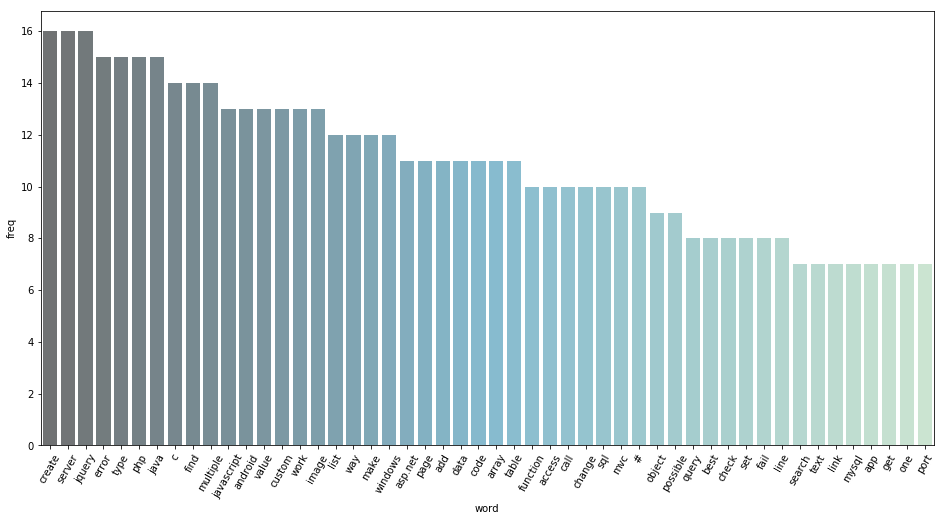

In [61]:
plt.figure(figsize=(16,8))
sns.barplot(y='freq',x='word',data=df_title_words.head(50),alpha=0.7,palette="GnBu_d")
plt.xticks(rotation=60)

From the distribution above, we can see that words such as *create, jquery, server and java* are some of the highest occurring words in the title column.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 50 Text xticklabel objects>)

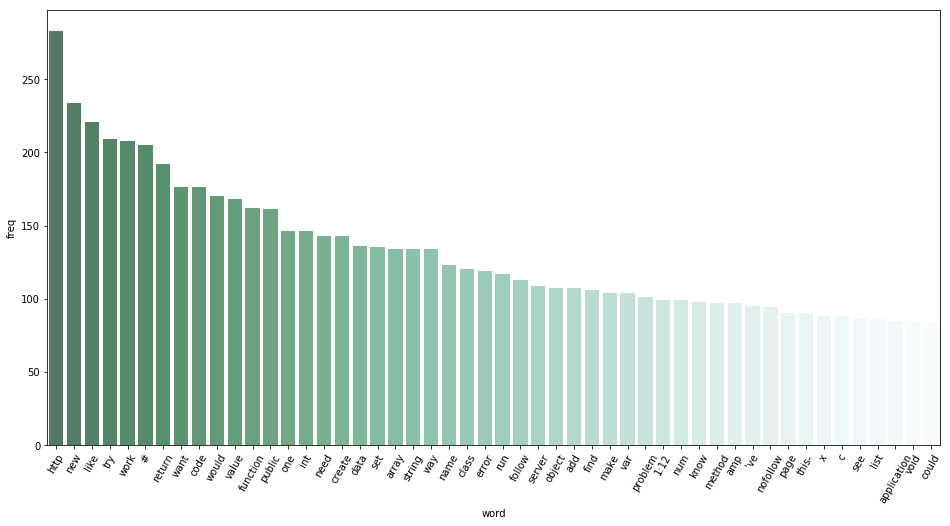

In [62]:
plt.figure(figsize=(16,8))
sns.barplot(y='freq',x='word',data=df_body_words.head(50),alpha=0.7,palette="BuGn_r")
plt.xticks(rotation=60)

The highest occurring words in the body column are *http, new, like, try and work*. It is interesting to notice that most of the frequent words in this case are more conversational words with a lot of verbs as compared to the words in the title column. This makes sense as the body contains more detailed descriptions while the title tends to contain more keywords. 

## b. Word frequencies using *WordCloud*

To visualize the highest occurring words in a more impactful manner, we construct a word cloud which really emphasizes more frequently occurring words. 

In [63]:
#Converting the list of tokenized words to a list containing all tokenized words in the dataset for use in the word cloud
all_title = []
all_body = []

for i in range(len(df_text['Title'])):
    all_title.extend(df_text.iloc[i,1])
    all_body.extend(df_text.iloc[i,2])
    
print (all_title[:100])
print ()
print (all_body[:100])

['check', 'upload', 'image', 'without', 'mime', 'type', 'prevent', 'firefox', 'close', 'press', 'ctrl-w', 'r', 'error', 'invalid', 'type', 'list', 'variable', 'replace', 'special', 'character', 'url', 'modify', 'whois', 'contact', 'detail', 'set', 'proxy', 'active', 'directory', 'environment', 'draw', 'barplot', 'way', 'coreplot', 'fetch', 'xml', 'fee', 'asp.net', '.net', 'library', 'generate', 'javascript', 'sql', 'server', 'procedure', 'call', 'inline', 'concatenation', 'impossible', 'commercial', 'obfuscators', 'achieve', 'crash', '.net', 'reflector', 'ildasm', 'crappy', 'random', 'number', 'generator', 'migrate', 'mdaemon', 'postfix', 'find', 'latex3', 'manual', 'stop', 'windows', 'fade', 'windows', 'alt-tab', 'php', 'framework', 'url', 'conventions', 'create', '.rds', 'temporary', 'file', 'r', 'wpf', 'multiple', 'control', 'bind', 'property', 'play', 'framework', 'auto', 'javascript', 'css', 'minifier', 'create', 'repetitive', 'node', 'hash', 'array', 'simplexml_load_string', 'cyc

In [64]:
#Converting the tokenized words into a single string for use in the word cloud function
all_title = ' '.join(all_title)
all_body = ' '.join(all_body)

print (all_title[:100])
print ()
print (all_body[:100])

check upload image without mime type prevent firefox close press ctrl-w r error invalid type list va

like check upload image e.g png jpg jpeg gif bmp another problem uploadify upload file change mime t


Below, we implement the word cloud for the *Title* column.

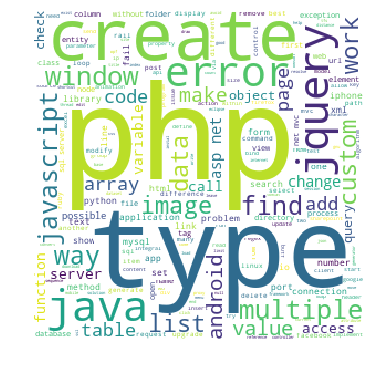

In [65]:
#Implementing the word cloud for the title
wordcloud = WordCloud(background_color="white", 
                      max_words=200, 
                      width=300, 
                      height=300, 
                      #mask=char_mask, 
                      ).generate(all_title) 
  
# plot the WordCloud image                        
plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

As seen from the histograms above, the word cloud also points out the more frequent words in larger font such as *php, type and create*. 

Below, we construct a similar word cloud for the body. 

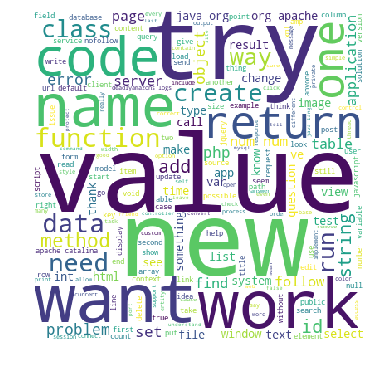

In [66]:
wordcloud = WordCloud(background_color="white", 
                      max_words=200, 
                      width=400, 
                      height=400, 
                      #mask=char_mask, 
                      ).generate(all_body) 
  
# plot the WordCloud image                        
plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

The body word cloud in comparison has more nouns and verbs as the frequently occurring words. 

## c. Part of speech tagging to remove unwanted tags

Removing verbs will be important for topic modeling as we are only interested in things like nouns, especially proper nouns. Verbs consist of actions which cannot be used as keywords. 

However, we will still keep a version of the dataset containing the verbs for comparison. 

#### Common POS tags:
- Nouns: NN
- Plural nouns: NNS
- Proper nouns: NNP, NNPS
- Verbs: VBP, VBN and VBD
- Adjectives: JJ, JJR, JJS
- Adverbs: RB, RBR (comparative), RBS (superlative)
- Cardinal numbers: CD

First let's explore all types of POS tags that exist in the dataset for both title and body.

In [67]:
pos_tags_title = []
pos_tags_body = []

for i in range(df_text.shape[0]):
    pos_tags_title.extend(nltk.pos_tag(df_text['Title'][i]))
    pos_tags_body.extend(nltk.pos_tag(df_text['Body'][i]))
    
pos_tags_title[:5]

[('check', 'NN'),
 ('upload', 'JJ'),
 ('image', 'NN'),
 ('without', 'IN'),
 ('mime', 'NN')]

Above, we have concatenated pos tags from each row of the dataset together to create a long list of tokens and tags in tuples. Next, we will separate the tokens and tags into separate lists to analyze them further. 

In [68]:
title_tokens = list(list(zip(*pos_tags_title))[0])
title_tags = list(list(zip(*pos_tags_title))[1])

body_tokens = list(list(zip(*pos_tags_body))[0])
body_tags = list(list(zip(*pos_tags_body))[1])

title_tags[:10]

['NN', 'JJ', 'NN', 'IN', 'NN', 'NN', 'NN', 'NN', 'JJ', 'NN']

Now we can visualize the frequencies of tags easily. 

Text(0.5, 0, 'Tags')

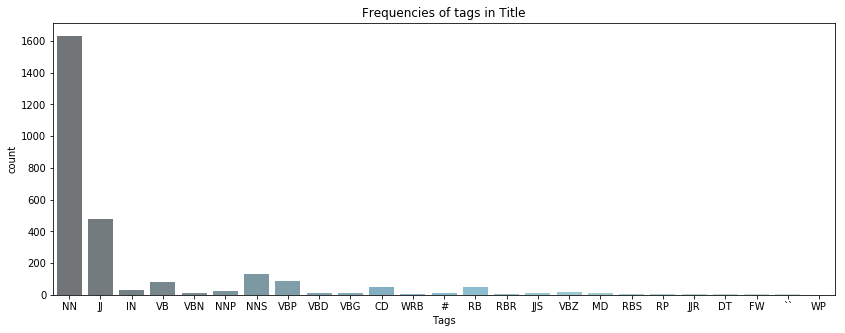

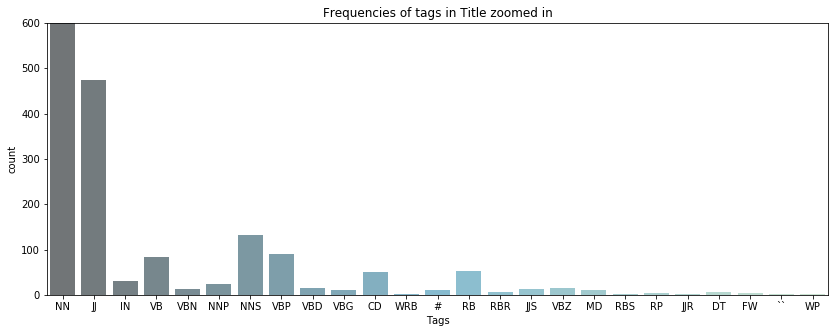

In [69]:
#Plotting tag frequencies for title
plt.figure(figsize=(14,5))
sns.countplot(title_tags,palette='GnBu_d',alpha=0.7)
plt.title("Frequencies of tags in Title")
plt.xlabel('Tags')

plt.figure(figsize=(14,5))
sns.countplot(title_tags,palette='GnBu_d',alpha=0.7)
plt.ylim(0,600)
plt.title("Frequencies of tags in Title zoomed in")
plt.xlabel('Tags')

In [70]:
#Finding highest occurring tags
print (pd.Series(title_tags).value_counts().head(20))

NN     1631
JJ      475
NNS     133
VBP      90
VB       83
RB       52
CD       50
IN       31
NNP      23
VBZ      16
VBD      14
VBN      13
JJS      12
MD       11
#        10
VBG      10
DT        7
RBR       6
FW        3
RP        3
dtype: int64


From the distributions above, we can see that nouns are by far the most frequent (1631) with adjectives coming in at second (475). The second plot above shows a scaled version of the first graph to show the frequencies of some of the less frequent tags more clearly. Verbs (VB, VBN, VBP, VBD etc) come up to around 300-400 in total while adverbs (RB, RBS, RBR) account for less than 100 of the instances. 

Next we look at the distribution for the body. 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36]), <a list of 37 Text xticklabel objects>)

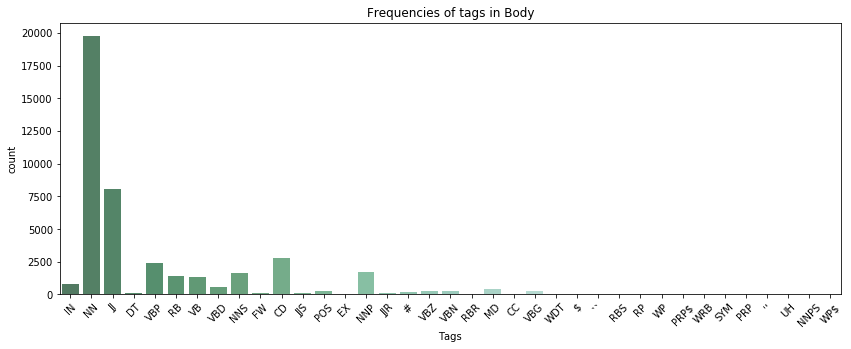

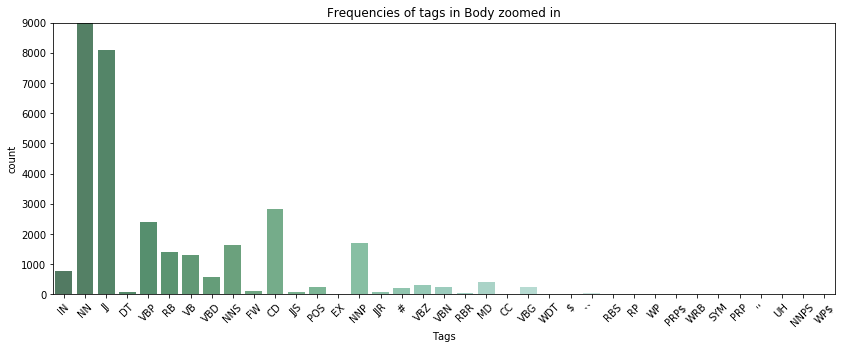

In [71]:
#Plotting tag frequencies for body
plt.figure(figsize=(14,5))
sns.countplot(body_tags,palette='BuGn_r',alpha=0.7)
plt.title("Frequencies of tags in Body")
plt.xlabel('Tags')
plt.xticks(rotation=45)

plt.figure(figsize=(14,5))
sns.countplot(body_tags,palette='BuGn_r',alpha=0.7)
plt.ylim(0,9000)
plt.title("Frequencies of tags in Body zoomed in")
plt.xlabel('Tags')
plt.xticks(rotation=45)

In [72]:
print ((pd.Series(body_tags)).value_counts().head(20))

NN     19786
JJ      8081
CD      2820
VBP     2394
NNP     1698
NNS     1645
RB      1408
VB      1301
IN       777
VBD      590
MD       405
VBZ      302
VBN      254
VBG      250
POS      249
#        205
FW       106
JJR       96
JJS       91
DT        85
dtype: int64


As expected, regular nouns (NN) make up 20,000 instances while adjectives show up around 8122 times. Interestingly, cardinal numbers (CD) are the next most frequent tags coming out to 2820 instances. The total numbers of verbs come out to around 5000 instances. 

Next, lets take a look at some examples of verbs since we want to remove them from the dataset. 

In [73]:
df_title_tags = pd.DataFrame()
df_title_tags['token'] = title_tokens
df_title_tags['tag'] = title_tags
df_title_tags.head()

,token,tag
0,check,NN
1,upload,JJ
2,image,NN
3,without,IN
4,mime,NN


#### Exploring verbs

Below, we extract all the verbs in the title and explore each one.

In [74]:
verbs = df_title_tags[df_title_tags['tag'].str.contains(r'V')]
verbs.head(10)

,token,tag
17,replace,VB
21,modify,VB
25,set,VBN
51,achieve,VBP
62,postfix,VBP
63,find,VB
68,fade,VBD
96,simplexml_load_string,VBG
130,make,VB
148,resolve,VBP


In [75]:
#Extracting frequency of words with VB tags
verbs[verbs['tag']=='VB']['token'].value_counts().head(10)

find         10
add           6
make          6
get           4
modify        4
remove        4
customize     3
save          2
check         2
start         2
Name: token, dtype: int64

In [76]:
#Extracting frequency of words with VBD tags
verbs[verbs['tag']=='VBD']['token'].value_counts().head(10)

draw          1
decompiled    1
html          1
fedora        1
accept        1
cms           1
fopen         1
shortcut      1
window        1
xslt          1
Name: token, dtype: int64

In [77]:
#Extracting frequency of words with VBN tags
verbs[verbs['tag']=='VBN']['token'].value_counts().head(10)

set              6
multithreaded    1
virtualized      1
saved/loaded     1
come             1
pad              1
ghost            1
shape            1
Name: token, dtype: int64

In [78]:
#Extracting frequency of words with VBP tags
verbs[verbs['tag']=='VBP']['token'].value_counts().head(10)

make       4
find       4
fail       4
object     2
require    2
take       2
get        2
leave      2
array      2
know       2
Name: token, dtype: int64

From the above analysis, we can see that most of the highest occurring verbs in the title column don't provide crucial words or keywords. These are mostly actions as and don't provide information such as topics. 

They could be used for a different type of analysis but perhaps not for topic modeling. 

Text(0, 0.5, 'Verb')

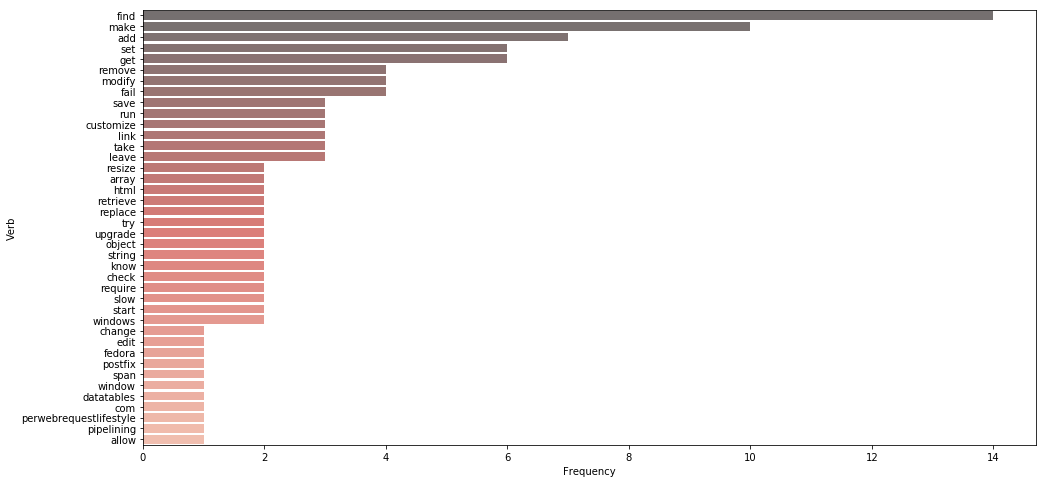

In [79]:
#Visualizing highest occurring verbs
plt.figure(figsize=(16,8))
sns.barplot(x=verbs['token'].value_counts().values[:40],y=verbs['token'].value_counts().index[:40],palette='Reds_d',alpha=0.7)
plt.xlabel('Frequency')
plt.ylabel('Verb')

From the highest occurring verbs, most of the words don't add much value for topic modeling. However, there are certain words that should really be in the **noun** category such as **windows, array, and html**. On the other hand, certain words could fall under both verb and noun depending on the meaning and context. Such words are **object, string, handle etc.**. The POS tagger is not going to be able to handle these intricacies. Although, I would hope that some of these words also show up as nouns so we don't have to delete them. 

#### Exploring adjectives

In [80]:
adj = df_title_tags[df_title_tags['tag'].str.contains(r'J')]
adj.head(10)

,token,tag
1,upload,JJ
8,close,JJ
13,invalid,JJ
16,variable,JJ
18,special,JJ
22,whois,JJ
26,proxy,JJ
27,active,JJ
38,.net,JJ
39,library,JJ


In [81]:
#Extracting frequency of words with VBP tags
adj[adj['tag']=='JJ']['token'].value_counts().head(20)

multiple     10
possible      9
android       8
table         8
library       7
c             6
open          6
new           6
different     5
url           5
select        4
variable      4
php           4
integral      4
many          3
good          3
instal        3
fail          3
current       3
certain       3
Name: token, dtype: int64

In [82]:
#Extracting frequency of words with VBP tags
adj[adj['tag']=='JJS']['token'].value_counts().head(20)

best       7
nest       2
latest     2
nearest    1
Name: token, dtype: int64

Text(0, 0.5, 'Adjective')

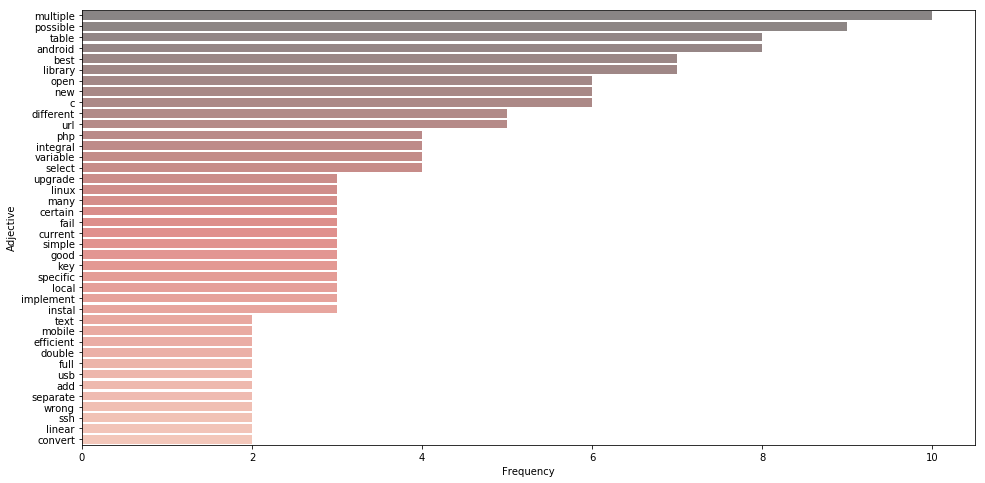

In [83]:
#Visualizing highest occurring adjectives
plt.figure(figsize=(16,8))
sns.barplot(x=adj['token'].value_counts().values[:40],y=adj['token'].value_counts().index[:40],palette='Reds_d',alpha=0.6)
plt.xlabel('Frequency')
plt.ylabel('Adjective')

When it comes to adjectives, the highest occurring words are accurate to a good extent but there are some keywords such as **android, library, c, url and php** that need to be preserved as they could serve as potential keywords. Overall, the adjectives seem to be more useful for topic modeling than verbs. Hence, we may end up retaining this category. 

#### Exploring adverbs

In [84]:
adv = df_title_tags[df_title_tags['tag'].str.contains(r'^R+')]
adv.head(10)

,token,tag
129,understand,RB
132,instead,RB
183,longer,RBR
360,menu,RB
362,mvc,RB
370,best,RBS
477,newly,RB
505,repeatedly,RB
530,reliably,RB
535,frequently,RB


Text(0, 0.5, 'Adverb')

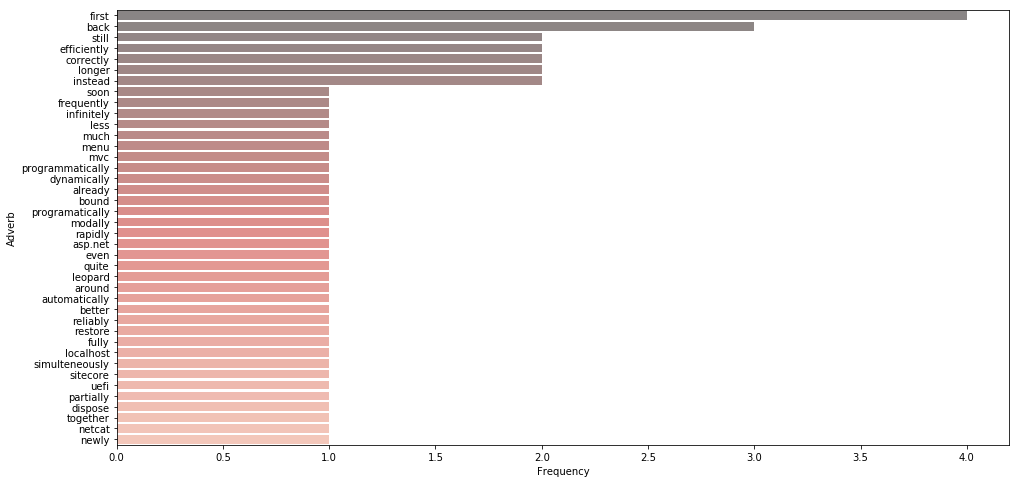

In [85]:
#Visualizing highest occurring adjectives
plt.figure(figsize=(16,8))
sns.barplot(x=adv['token'].value_counts().values[:40],y=adv['token'].value_counts().index[:40],palette='Reds_d',alpha=0.6)
plt.xlabel('Frequency')
plt.ylabel('Adverb')

Since adverbs describe an action (or verb), a lot of these words would be similar to verbs themselves. Hence, similar to verbs, adverbs don't really provide a lot of keywords for our analysis. We can possibly get rid of these. 

#### Exploring nouns

In [86]:
noun = df_title_tags[df_title_tags['tag'].str.contains(r'^N+')]
noun.head(10)

,token,tag
0,check,NN
2,image,NN
4,mime,NN
5,type,NN
6,prevent,NN
7,firefox,NN
9,press,NN
10,ctrl-w,NN
11,r,NN
12,error,NN


In [87]:
#Extracting frequency of words with NN tags
print (noun[noun['tag']=='NN']['token'].value_counts().head(20))

jquery        16
create        15
java          15
type          14
server        14
error         14
custom        13
javascript    13
value         13
image         13
list          12
work          12
way           12
page          11
php           11
access        10
code          10
function      10
sql            9
change         9
Name: token, dtype: int64


In [88]:
#Extracting frequency of words with NNS tags
print (noun[noun['tag']=='NNS']['token'].value_counts().head(20))

windows         10
data            10
ios              5
variables        4
paths            2
c                2
options          2
permissions      2
items            2
entities         2
browsers         2
cells            2
applications     2
elements         2
iptables         2
bullets          1
domains          1
subsequences     1
controllers      1
visitors         1
Name: token, dtype: int64


In [89]:
#Extracting frequency of words with NNS tags
noun[noun['tag']=='NNP']['token'].value_counts().head(20)

xml              2
.net             2
x                2
\mathrm          2
x3220            1
.png             1
-\frac           1
-1               1
.h               1
.pfd             1
.attr            1
–                1
\int_0^\infty    1
\infty           1
.fadein          1
xmlserializer    1
xen              1
++=              1
\                1
Name: token, dtype: int64

Note that a lot of the proper nouns are strange strings such as **x322, .pfd, \infty**. It may be useful to get rid of this particular category. Although, from the table above, tokens such as **xml** are important so we would need to find a way to preserve those. 

In [90]:
#Extracting frequency of words with NNPS tags
noun[noun['tag']=='NNPS']['token'].value_counts().head(20)

Series([], Name: token, dtype: int64)

Text(0, 0.5, 'Noun')

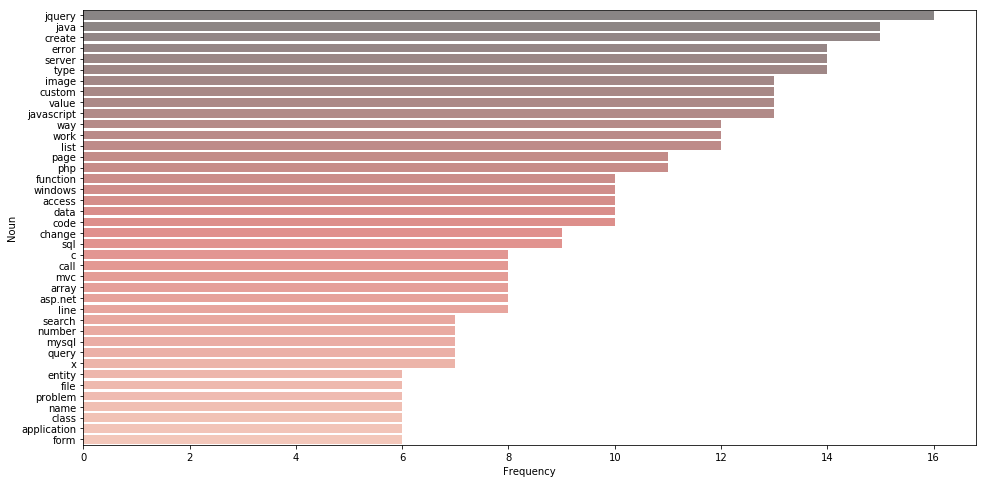

In [91]:
#Visualizing highest occurring nouns
plt.figure(figsize=(16,8))
sns.barplot(x=noun['token'].value_counts().values[:40],y=noun['token'].value_counts().index[:40],palette='Reds_d',alpha=0.6)
plt.xlabel('Frequency')
plt.ylabel('Noun')

### Exploring POS tags for the *Body* column

In [92]:
df_body_tags = pd.DataFrame()
df_body_tags['token'] = body_tokens
df_body_tags['tag'] = body_tags
df_body_tags.head()

,token,tag
0,like,IN
1,check,NN
2,upload,JJ
3,image,NN
4,e.g,NN


In [93]:
noun_body = df_body_tags[df_body_tags['tag'].str.contains(r'^N+')]
verb_body = df_body_tags[df_body_tags['tag'].str.contains(r'^V+')]
adj_body = df_body_tags[df_body_tags['tag'].str.contains(r'^J+')]
adv_body = df_body_tags[df_body_tags['tag'].str.contains(r'^R+')]

noun_body.head()

,token,tag
1,check,NN
3,image,NN
4,e.g,NN
5,png,NN
6,jpg,NN


Text(0, 0.5, 'Verb')

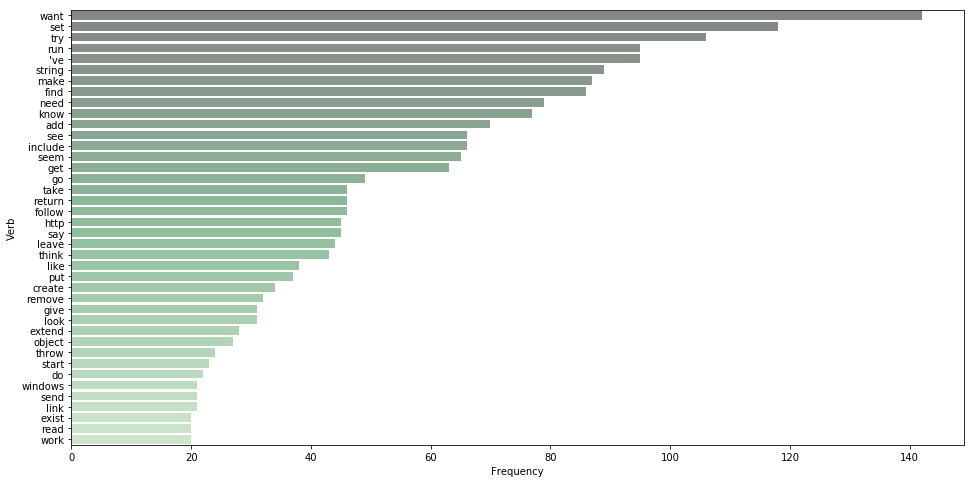

In [94]:
#Visualizing highest occurring verbs
plt.figure(figsize=(16,8))
sns.barplot(x=verb_body['token'].value_counts().values[:40],y=verb_body['token'].value_counts().index[:40],palette='Greens_d',alpha=0.6)
plt.xlabel('Frequency')
plt.ylabel('Verb')

Text(0, 0.5, 'Adjective')

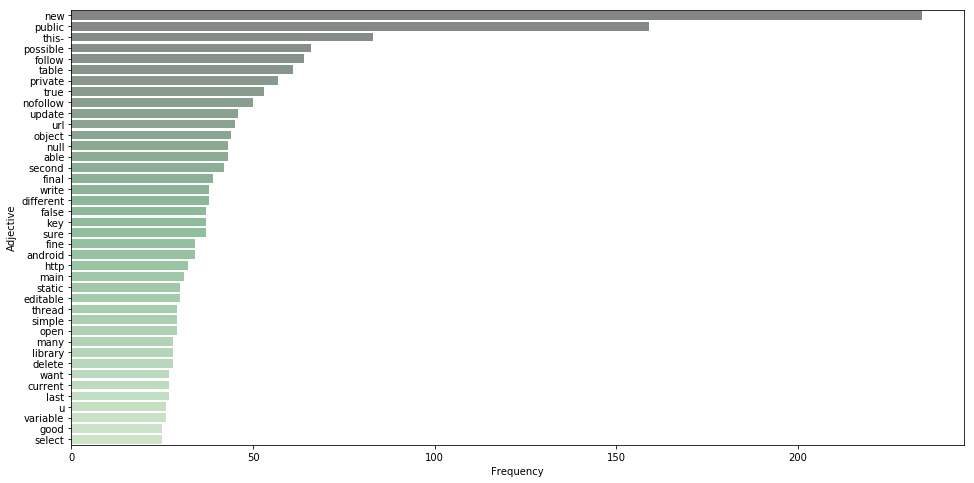

In [95]:
#Visualizing highest occurring adjectives
plt.figure(figsize=(16,8))
sns.barplot(x=adj_body['token'].value_counts().values[:40],y=adj_body['token'].value_counts().index[:40],palette='Greens_d',alpha=0.6)
plt.xlabel('Frequency')
plt.ylabel('Adjective')

Text(0, 0.5, 'Adverbs')

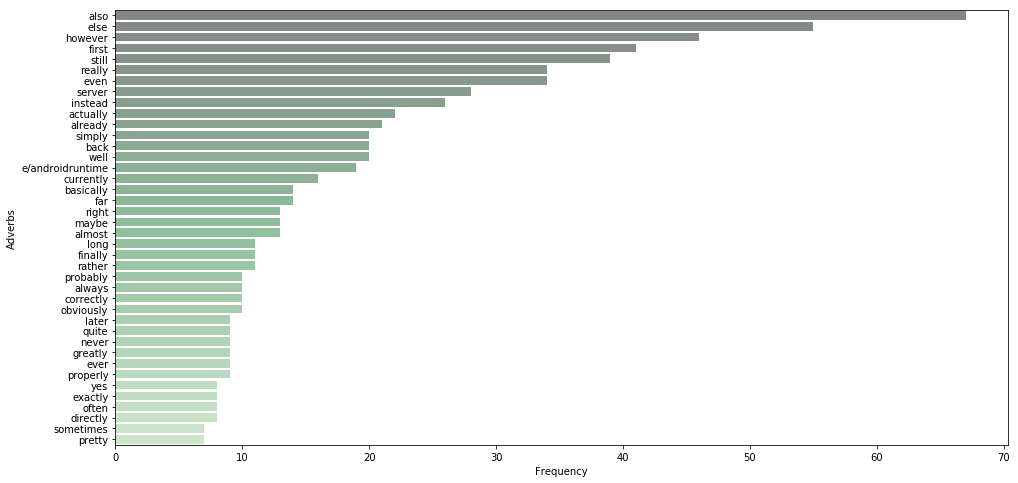

In [96]:
#Visualizing highest occurring adverbs
plt.figure(figsize=(16,8))
sns.barplot(x=adv_body['token'].value_counts().values[:40],y=adv_body['token'].value_counts().index[:40],palette='Greens_d',alpha=0.6)
plt.xlabel('Frequency')
plt.ylabel('Adverbs')

Text(0, 0.5, 'Noun')

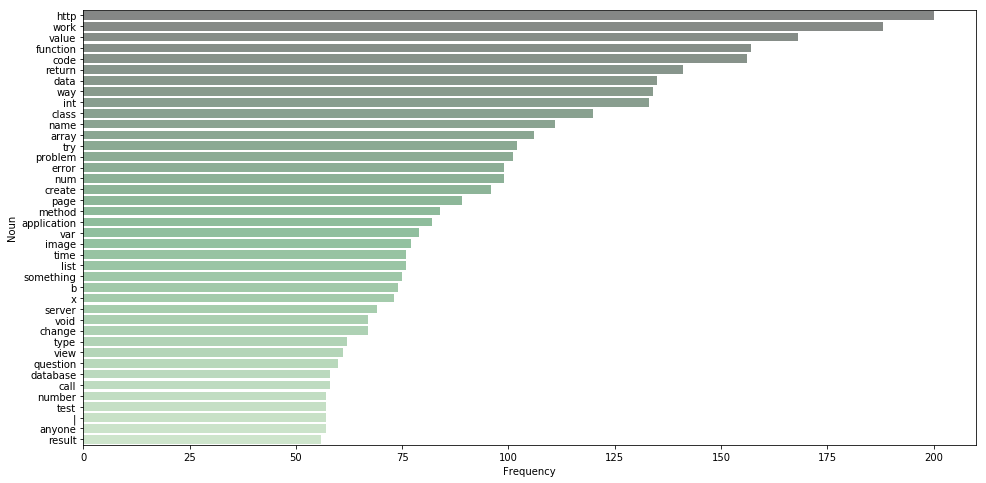

In [97]:
#Visualizing highest occurring nouns
plt.figure(figsize=(16,8))
sns.barplot(x=noun_body['token'].value_counts().values[:40],y=noun_body['token'].value_counts().index[:40],palette='Greens_d',alpha=0.6)
plt.xlabel('Frequency')
plt.ylabel('Noun')

From the body plots, it's even more clear that only the **noun** category contains the important keywords. To make sure that we are not ignoring some of the keywords from the other POS tags, let's check if these are in nouns as well in which case we should be good to go. 

In [98]:
noun[noun['token']=='http']

,token,tag
791,http,NN
1542,http,NN
2209,http,NN


In [99]:
noun[noun['token']=='xml']

,token,tag
35,xml,NNP
312,xml,NNS
1320,xml,NN
2679,xml,NNP


In [100]:
noun[noun['token']=='c']

,token,tag
190,c,NNS
732,c,NN
895,c,NN
1204,c,NN
1216,c,NN
1512,c,NNS
1995,c,NN
2608,c,NN


In [101]:
noun[noun['token']=='php']

,token,tag
71,php,NN
209,php,NN
534,php,NN
712,php,NN
969,php,NN
1076,php,NN
1247,php,NN
1611,php,NN
2519,php,NN
2543,php,NN


In [102]:
noun[noun['token']=='r']

,token,tag
11,r,NN
79,r,NN
1227,r,NNS
2277,r,NN


Looks like there are more than enough of these words in the noun category, so we can get rid of the ones in the other tags. 

#### Removing tags other than nouns

In [103]:
df_title_tags.head()

,token,tag
0,check,NN
1,upload,JJ
2,image,NN
3,without,IN
4,mime,NN


In [104]:
#Only selecting nouns
df_title_noun = df_title_tags[(df_title_tags['tag']=='NN') | (df_title_tags['tag']=='NNS') | (df_title_tags['tag']=='NNP') | (df_title_tags['tag']=='NNPS')]
df_title_noun.head(20)

,token,tag
0,check,NN
2,image,NN
4,mime,NN
5,type,NN
6,prevent,NN
7,firefox,NN
9,press,NN
10,ctrl-w,NN
11,r,NN
12,error,NN


In [105]:
df_body_tags.head()

,token,tag
0,like,IN
1,check,NN
2,upload,JJ
3,image,NN
4,e.g,NN


In [106]:
#Only selecting nouns
df_body_noun = df_body_tags[(df_body_tags['tag']=='NN') | (df_body_tags['tag']=='NNS') | (df_body_tags['tag']=='NNP') | (df_body_tags['tag']=='NNPS')]
df_body_noun.head(20)

,token,tag
1,check,NN
3,image,NN
4,e.g,NN
5,png,NN
6,jpg,NN
7,jpeg,NN
8,gif,NN
9,bmp,NN
11,problem,NN
12,uploadify,NN


## d. Getting word frequencies following POS tagging

In [107]:
df_title_words = pd.DataFrame()
df_title_words['word'] = nltk.FreqDist(df_title_noun['token']).keys()
df_title_words['freq'] = nltk.FreqDist(df_title_noun['token']).values()

df_title_words = df_title_words.sort_values("freq",ascending=False)
df_title_words.head(10)

,word,freq
130,jquery,16
48,create,15
111,java,15
3,type,14
28,server,14
9,error,14
87,custom,13
26,javascript,13
255,value,13
1,image,13


In [108]:
df_body_words = pd.DataFrame()
df_body_words['word'] = nltk.FreqDist(df_body_noun['token']).keys()
df_body_words['freq'] = nltk.FreqDist(df_body_noun['token']).values()

df_body_words = df_body_words.sort_values("freq",ascending=False)
df_body_words.head(20)

,word,freq
88,http,200
185,work,188
250,value,168
100,function,157
47,code,156
118,return,141
32,data,135
17,way,134
503,int,133
93,class,120


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 50 Text xticklabel objects>)

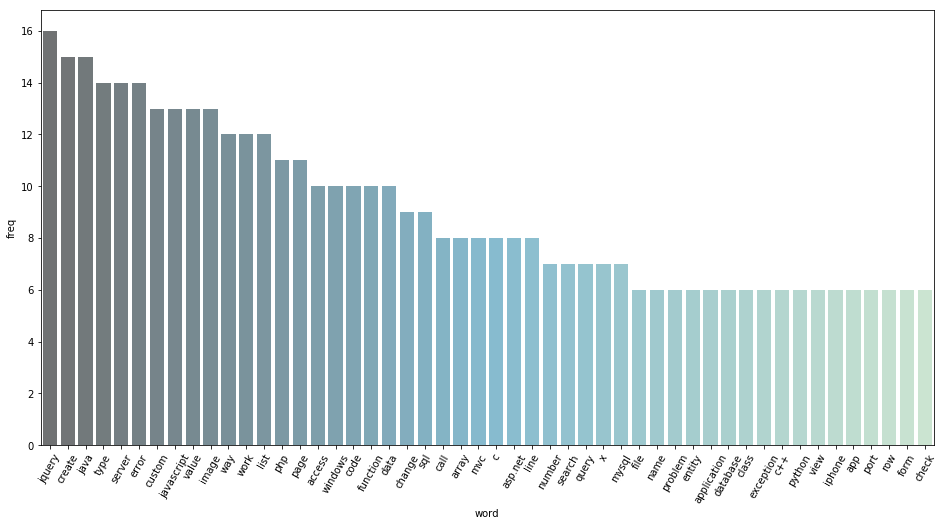

In [109]:
plt.figure(figsize=(16,8))
sns.barplot(y='freq',x='word',data=df_title_words.head(50),alpha=0.7,palette="GnBu_d")
plt.xticks(rotation=60)

From the distribution above, we can see that words such as *create, jquery, server and java* are some of the highest occurring words in the title column.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 50 Text xticklabel objects>)

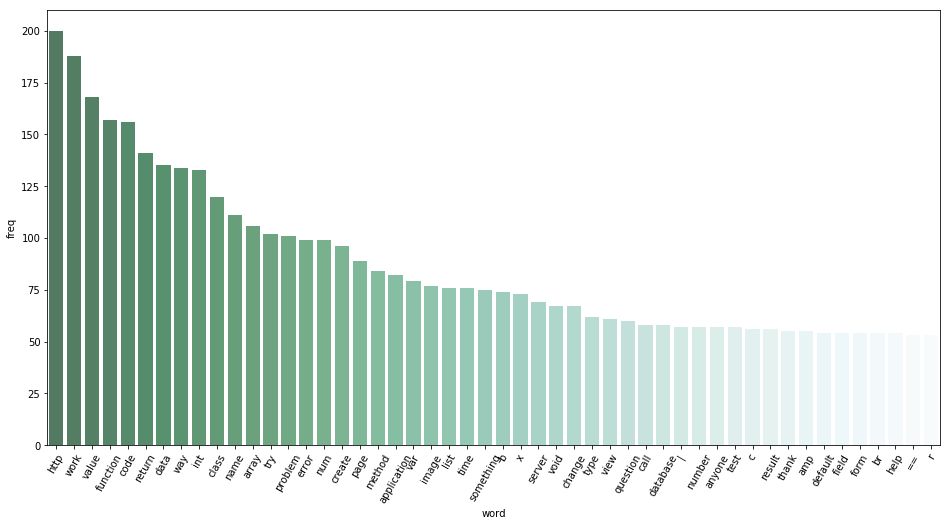

In [110]:
plt.figure(figsize=(16,8))
sns.barplot(y='freq',x='word',data=df_body_words.head(50),alpha=0.7,palette="BuGn_r")
plt.xticks(rotation=60)

The highest occurring words in the body column are *http, new, like, try and work*. It is interesting to notice that most of the frequent words in this case are more conversational words with a lot of verbs as compared to the words in the title column. This makes sense as the body contains more detailed descriptions while the title tends to contain more keywords. 

## e. Word frequencies using *WordCloud* following POS tagging

In [111]:
#Converting the tokenized words into a single string for use in the word cloud function
all_title = ' '.join(df_title_noun['token'])
all_body = ' '.join(df_body_noun['token'])

print (all_title[:100])
print ()
print (all_body[:100])

check image mime type prevent firefox press ctrl-w r error type list character url contact detail di

check image e.g png jpg jpeg gif bmp problem uploadify upload file change mime type something matter


Below, we implement the word cloud for the *Title* column.

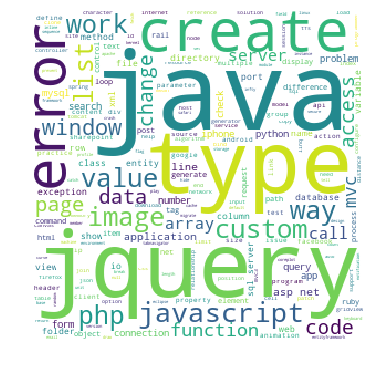

In [112]:
#Implementing the word cloud for the title
wordcloud = WordCloud(background_color="white", 
                      max_words=200, 
                      width=300, 
                      height=300, 
                      #mask=char_mask, 
                      ).generate(all_title) 
  
# plot the WordCloud image                        
plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

As seen from the histograms above, the word cloud also points out the more frequent words in larger font such as *php, type and create*. 

Below, we construct a similar word cloud for the body. 

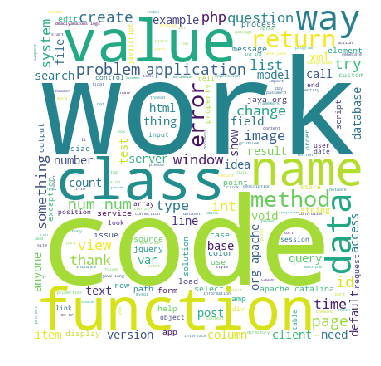

In [113]:
wordcloud = WordCloud(background_color="white", 
                      max_words=200, 
                      width=400, 
                      height=400, 
                      #mask=char_mask, 
                      ).generate(all_body) 
  
# plot the WordCloud image                        
plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

The body word cloud in comparison has more nouns and verbs as the frequently occurring words. 

## f. Getting only *nouns* in document format

Previously, when we explored the POS tags, we did it by extracting each and every words and putting them in a single list. To analyze the word frequencies, we simply used this list. However, in order to conduct topic modeling using techniques such as Latent Dirichlet Allocation (LDA), the dataset needs to be in a **document-term matrix** format. Therefore, we need to keep the nouns but still have the tokens in a document form. 

In [117]:
df_text['Title'].head(10)

0          [check, upload, image, without, mime, type]
1             [prevent, firefox, close, press, ctrl-w]
2            [r, error, invalid, type, list, variable]
3                   [replace, special, character, url]
4                     [modify, whois, contact, detail]
5         [set, proxy, active, directory, environment]
6                       [draw, barplot, way, coreplot]
7                           [fetch, xml, fee, asp.net]
8                [.net, library, generate, javascript]
9    [sql, server, procedure, call, inline, concate...
Name: Title, dtype: object

In [175]:
#Function to read in lists of tokens and return the list with only nouns 
def keep_nouns_in_doc(doc_list):
    tags = nltk.pos_tag(doc_list)
    tags = list(zip(*tags))
    doc_list_nouns = []
    for i in range(len(tags[0])):
        if tags[1][i].startswith('NN'):
            doc_list_nouns.append(tags[0][i])
    return doc_list_nouns

In [192]:
#Applying the above function to the dataset
df_text_nouns = pd.DataFrame()
df_text_nouns['Title'] = df_text['Title'].apply(keep_nouns_in_doc)
df_text_nouns['Body'] = df_text['Body'].apply(keep_nouns_in_doc)
df_text_nouns.head(10)

,Title,Body
0,"[check, image, mime, type]","[check, image, e.g, png, jpg, jpeg, gif, bmp, ..."
1,"[prevent, firefox, press, ctrl-w]","[editor, execute, action, firefox, window, win..."
2,"[r, error, type, list]","[import, matlab, construct, data, frame, matla..."
3,"[character, url]","[basicaly, string, http, //www.google.com/sear..."
4,"[contact, detail]","[function, file_get_contents, //test.httpapi.c..."
5,"[directory, environment]","[machine, directory, configure, application, m..."
6,"[draw, barplot, way, coreplot]","[image, post, picture, img, src=, http, //i.st..."
7,"[fetch, xml, fee, asp.net]","[convert, phone, app, fetch, xml, fee, parse, ..."
8,"[generate, javascript]","[.net, library, generate, javascript, code, ge..."
9,"[sql, server, procedure, call, inline, concate...","[sql, server, r2, wonder, way, something, dbo...."


To verify that our transformation worked, we can look at the word frequencies once again briefly.

In [202]:
title_words = combine_list_of_words(df_text_nouns['Title'])

df_title_words = pd.DataFrame()
df_title_words['word'] = nltk.FreqDist(title_words).keys()
df_title_words['freq'] = nltk.FreqDist(title_words).values()

df_title_words = df_title_words.sort_values("freq",ascending=False)
df_title_words.head(10)

,word,freq
130,jquery,16
48,create,15
111,java,15
3,type,14
28,server,14
9,error,14
87,custom,13
26,javascript,13
255,value,13
1,image,13


Looking at the table above for the highest occurring words in the **Title** column, the top entries match the list we observed earlier. So I think we should be good to proceed. 

In [203]:
df_text_nouns.head()

,Title,Body
0,"[check, image, mime, type]","[check, image, e.g, png, jpg, jpeg, gif, bmp, ..."
1,"[prevent, firefox, press, ctrl-w]","[editor, execute, action, firefox, window, win..."
2,"[r, error, type, list]","[import, matlab, construct, data, frame, matla..."
3,"[character, url]","[basicaly, string, http, //www.google.com/sear..."
4,"[contact, detail]","[function, file_get_contents, //test.httpapi.c..."


In [208]:
def join_words(list_of_words):
    return ' '.join(list_of_words)

In [210]:
df_text_nouns['Title'] = df_text_nouns['Title'].apply(join_words)
df_text_nouns['Body'] = df_text_nouns['Body'].apply(join_words)

df_text_nouns.head()

,Title,Body
0,check image mime type,check image e.g png jpg jpeg gif bmp problem u...
1,prevent firefox press ctrl-w,editor execute action firefox window windows w...
2,r error type list,import matlab construct data frame matlab cont...
3,character url,basicaly string http //www.google.com/search h...
4,contact detail,function file_get_contents //test.httpapi.com/...


In [211]:
df_text_nouns.to_csv('cleaned_stack_exchange_dataset.csv')

## Apply Unicode library

In [114]:
unicodedata.normalize('NFKD', df['Body'][34]).encode('ascii', 'ignore').decode('utf-8', 'ignore')

'<p>I have a wpf-mvvm application.</p>\n\n<p>I have a base class - baseViewModel...</p>\n\n<p>and two other classes, which inherit this base class</p>\n\n<pre><code> class aVM : baseViewModel\n    {\n       public string a {get;set;}\n    }\n\n    class bVM : baseViewModel\n    {\n      public string b {get;set;}\n    }\n</code></pre>\n\n<p>And another class- as main viewmodel - which bind to main view.</p>\n\n<pre><code>   Class MainVM\n   {\n     public baseViewModel CurrentViewSource  {get;set;}\n   }\n</code></pre>\n\n<p>Also In XAML file (view) - I have two user controls. But the data context of both of these are same public property - CurrentViewSource - this is of type - baseViewModel.</p>\n\n<pre><code>&lt;---MainView start DataContext="MainVM" -----&gt;\n\n&lt;---user control 1 satrt-----&gt;\n  &lt;--DataContext = "CurrentViewSource " --&gt;\n  // Here CurrentViewSource  is of type aVM\n&lt;---user control 1 end -----&gt;\n\n&lt;---user control 2 start-----&gt;\n  &lt;-- Data

In [115]:
df['Body'][34]

'<p>I have a wpf-mvvm application.</p>\n\n<p>I have a base class - baseViewModel...</p>\n\n<p>and two other classes, which inherit this base class</p>\n\n<pre><code> class aVM : baseViewModel\n    {\n       public string a {get;set;}\n    }\n\n    class bVM : baseViewModel\n    {\n      public string b {get;set;}\n    }\n</code></pre>\n\n<p>And another class- as main viewmodel - which bind to main view.</p>\n\n<pre><code>   Class MainVM\n   {\n     public baseViewModel CurrentViewSource  {get;set;}\n   }\n</code></pre>\n\n<p>Also In XAML file (view) - I have two user controls. But the data context of both of these are same public property - CurrentViewSource - this is of type - baseViewModel.</p>\n\n<pre><code>&lt;---MainView start DataContext="MainVM" -----&gt;\n\n&lt;---user control 1 satrt-----&gt;\n  &lt;--DataContext = "CurrentViewSource " --&gt;\n  // Here CurrentViewSource  is of type aVM\n&lt;---user control 1 end -----&gt;\n\n&lt;---user control 2 start-----&gt;\n  &lt;-- Data